# Pose Estimation (Camera)
This notebook presents the demonstration of pose estimation with ICP of a book for the LibreBot by T2325.

In [1]:

# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib


In [2]:
# !pip install transformers
# !pip install requests
# !pip install torchvision
# !pip install Pillow
# !pip install git+https://github.com/facebookresearch/segment-anything.git



# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib




# import torch
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import cv2

# def show_anns(anns):
#     if len(anns) == 0:
#         return
#     sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
#     ax = plt.gca()
#     ax.set_autoscale_on(False)
#     polygons = []
#     color = []
#     for ann in sorted_anns:
#         m = ann['segmentation']
#         img = np.ones((m.shape[0], m.shape[1], 3))
#         color_mask = np.random.random((1, 3)).tolist()[0]
#         for i in range(3):
#             img[:,:,i] = color_mask[i]
#         ax.imshow(np.dstack((img, m*0.35)))

# import sys
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor



# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

# #device = "cuda"
# device = torch.device("cpu")


# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)
# import cv2 


In [3]:
import numpy as np
from pydrake.all import (AbstractValue, AngleAxis, Concatenate, DiagramBuilder,
                         LeafSystem, MeshcatVisualizer, PiecewisePolynomial,
                         PiecewisePose, PointCloud, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat)

from manipulation import running_as_notebook
from manipulation.icp import IterativeClosestPoint
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.mustard_depth_camera_example import MustardPointCloud
from manipulation.pick import (MakeGripperCommandTrajectory, MakeGripperFrames,
                               MakeGripperPoseTrajectory)
from manipulation.scenarios import *
from manipulation.scenarios import (AddIiwaDifferentialIK,
                                    MakeManipulationStation)
                                    
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
import CrackerBoxPointCloud
from IPython.display import SVG, clear_output, display
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis,
                         DiagramBuilder, FindResourceOrThrow, Integrator,
                         JacobianWrtVariable, LeafSystem, MathematicalProgram,
                         MeshcatVisualizer, SnoptSolver, Solve, eq, ge, le,
                         MultibodyPlant, MultibodyPositionToGeometryPose,
                         Parser, PiecewisePolynomial, PiecewisePose,
                         Quaternion, Rgba, RigidTransform, RotationMatrix,
                         SceneGraph, Simulator, StartMeshcat, TrajectorySource)
from pydrake.all import (AbstractValue, AngleAxis, Concatenate, DiagramBuilder,
                         LeafSystem, MeshcatVisualizer, PiecewisePolynomial,
                         PiecewisePose, PointCloud, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat)

from manipulation import running_as_notebook, FindResource
from manipulation.scenarios import (AddIiwaDifferentialIK,
                                    MakeManipulationStation, AddMultibodyTriad,
                                    AddShape)

from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.manipulation.planner import (
    DifferentialInverseKinematicsIntegrator,
    DifferentialInverseKinematicsParameters,
    DifferentialInverseKinematicsStatus)
from pydrake.manipulation.planner import DoDifferentialInverseKinematics
from manipulation.icp import IterativeClosestPoint
from pydrake.all import (Box, Sphere, PrismaticJoint, RevoluteJoint, SpatialInertia, UnitInertia) #PlanarJoint
from datetime import datetime

if running_as_notebook:
    mpld3.enable_notebook()



def saat(msg=""):
    print(str(datetime.now()), msg)
saat()

2023-05-11 10:02:20.759665 


In [4]:
from pydrake.systems.sensors import (
    CameraInfo,
    ImageDepth32F,
    ImageLabel16I,
    ImageRgba8U,
    RgbdSensor,
)

In [5]:
# print(str(datetime.now()))
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [6]:
model_directives = """
directives:
- add_model:
    name: iiwa
    file: file://psets/psets/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf
    # file: file://root/work/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf
    # file: file://root/work/iiwa_description/iiwa7/iiwa7_no_collision.sdf
        
    # file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf 

    default_joint_positions:
        iiwa_joint_0_x: [0.0]
        iiwa_joint_0_y: [0.0]
        iiwa_joint_0_z: [0.0]
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
    X_PC:
        translation: [0, -0.1, 0.0]
        rotation: !Rpy { deg: [0, 0, 0]}
- add_model:
    name: wsg
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, -0., 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}

- add_model:
    name: iiwa2
    file: file://psets/psets/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf
    # file: file://root/work/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf
    # file: file://root/work/iiwa_description/iiwa7/iiwa7_no_collision.sdf
        
    # file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf 

    default_joint_positions:
        iiwa_joint_0_x: [2.0]
        iiwa_joint_0_y: [2.0]
        iiwa_joint_0_z: [0.0]
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa2::iiwa_link_0
    X_PC:
        translation: [0, -0.1, 0.0]
        rotation: !Rpy { deg: [0, 0, 0]}
- add_model:
    name: wsg2
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa2::iiwa_link_7
    child: wsg2::body
    X_PC:
        translation: [0, -0., 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}

- add_frame:
    name: bin0_origin
    X_PF:
      base_frame: world
      rotation: !Rpy { deg: [0.0, 70.0, 90.0 ]}
      translation: [-0.1, -1.1, 0.45]

- add_model:
    name: bin0
    file: package://drake/examples/manipulation_station/models/bin.sdf

- add_weld:
    parent: bin0_origin
    child: bin0::bin_base

- add_frame:
    name: shelf1_goal
    X_PF:
      base_frame: world
      rotation: !Rpy { deg: [0.0, 0, 110.0 ]}
      translation: [0.95, -0.3, 0.48]

- add_model:
    name: shelf1
    file: package://manipulation/shelves.sdf

- add_weld:
    parent: shelf1_goal
    child: shelf1::shelves_body


- add_model:
    name: floor
    file: package://manipulation/floor.sdf

- add_weld:
    parent: world
    child: floor::box
    X_PC:
        translation: [0, 0, -.5]

# cracker box
# add cracker box
- add_model:
    name: cracker_box
    file: package://drake/manipulation/models/ycb/sdf/003_cracker_box.sdf
    default_free_body_pose:
        base_link_cracker:
            translation: [-0.1, -0.95, 0.45]
            rotation: !Rpy { deg: [-90, 0, 90] }

# add cameras
- add_frame:
    name: camera3_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [80., 150, -40]}
        translation: [0.25, -.5, .5]

- add_model:
    name: camera3
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera3_origin
    child: camera3::base

- add_frame:
    name: camera4_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [50, 180, 0]}
        translation: [-0.05, -.4, 1]

- add_model:
    name: camera4
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera4_origin
    child: camera4::base

- add_frame:
    name: camera5_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [80., 210, 50]}
        translation: [-0.5, -.5, .5]

- add_model:
    name: camera5
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera5_origin
    child: camera5::base

""" 

saat("model directives defined")

2023-05-11 10:02:20.984908 model directives defined


# Putting it all together

In the code above, we worked with a point cloud using functions.  To assemble this into a full-stack manipulation system, we need to specify the timing semantics of when those functions are called.  That's precisely what Drake's systems framework provides.  I've introduced two systems below: 
- `MustardIterativeClosestPoint` system that takes the camera inputs and outputs the pose estimate using ICP, and 
- `PickAndPlaceTrajectory` system that takes this pose estimate (and the state of the robot), computes the trajectory, and stores that trajectory in its Context so that it can output the instantaneous command.  

We don't use a `TrajectorySource` here, because the trajectory is not known when we first build the Diagram... the information we need to plan the trajectory requires reading sensors at runtime.

In [7]:
def VectorizedMakeGripperFrames(X_G, X_O):
    
    """
    Takes a partial specification with X_G[]["initial"] and X_O[]["initial"] and
    X_0[]["goal"], X_G[]["pick"] and returns a X_G[] and times[] with all of the pick and place
    frames populated.
    """

    
    # Now let's set the timing
    times = [dict() for x in range(2)]
    # X_GgraspO = RigidTransform( RotationMatrix.MakeXRotation(np.pi)  ,[0.03,0.05,0.06])
    # X_OGgrasp = X_GgraspO.inverse()


    X_GgraspGpregrasp = RigidTransform([0, -0.2, 0])

    for i in range(2):
        # X_G[i]["pick"] = X_O[i]["initial"] @ X_OGgrasp

        X_G[i]["prepick"] = X_G[i]["pick"] @ X_GgraspGpregrasp
        X_G[i]["place"] = X_O[i]["goal"]
        X_G[i]["preplace"] = X_G[i]["place"] @ X_GgraspGpregrasp

        # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
        X_GprepickGpreplace = X_G[i]["prepick"].inverse() @ X_G[i]["preplace"]
        angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
        X_GprepickGclearance = RigidTransform(
            AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
            X_GprepickGpreplace.translation() / 2.0 + np.array([0, 0, -0.3]),
        )

    
        X_G[i]["clearance"] = RigidTransform( RotationMatrix.MakeXRotation(np.pi), [0.0, 0.0, 0.40])

        if i == 0:
            times[i] = {"initial": 0}
            X_G[0]["initial_to_prepick"] = X_G[0]["initial"]
        else:
            times[i] = {"initial": times[i-1]["postplace"] + 4}
            X_G[i]["initial"] = X_G[i-1]["postplace"]
            # X_G[i]["initial"] = X_G[0]["initial"]
            X_G[i]["initial_to_prepick"] = RigidTransform( RotationMatrix.MakeXRotation(np.pi), [0.0, 0.0, 0.40])

        X_GinitialGprepick = X_G[i]["initial"].inverse() @ X_G[i]["prepick"]
        times[i]["initial_to_prepick"] = times[i]["initial"] + (10.0 * np.linalg.norm(
            X_GinitialGprepick.translation()
        )) / 2

        times[i]["prepick"] = times[i]["initial"] + 10.0 * np.linalg.norm(
            X_GinitialGprepick.translation()
        )

        # Allow some time for the gripper to close.
        times[i]["pick_start"] = times[i]["prepick"] + 2.0
        times[i]["pick_end"] = times[i]["pick_start"] + 2.0
        X_G[i]["pick_start"] = X_G[i]["pick"]
        X_G[i]["pick_end"] = X_G[i]["pick"]
        times[i]["postpick"] = times[i]["pick_end"] + 2.0
        X_G[i]["postpick"] = X_G[i]["prepick"]
        time_to_from_clearance = 10.0 * np.linalg.norm(X_GprepickGclearance.translation())
        times[i]["clearance"] = times[i]["postpick"] + time_to_from_clearance
        times[i]["preplace"] = times[i]["clearance"] + time_to_from_clearance
        times[i]["place_start"] = times[i]["preplace"] + 2.0
        times[i]["place_end"] = times[i]["place_start"] + 2.0
        X_G[i]["place_start"] = X_G[i]["place"]
        X_G[i]["place_end"] = X_G[i]["place"]
        times[i]["postplace"] = times[i]["place_end"] + 2.0
        X_G[i]["postplace"] = X_G[i]["preplace"]


    return X_G, times

In [8]:
# write a function that returns the corner points of a given image , where 1's are objects and 0's are background
def get_corners(img):
    # img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.goodFeaturesToTrack(gray, 100, 0.01, 10)
    corners = np.int0(corners)
    corner_list = []
    for corner in corners:
        x, y = corner.ravel()
        corner_list.append([x,y])
    return corner_list



In [9]:
def VectorizedMakeGripperPoseTrajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    sample_times = []
    poses = []
    for i in range(2):
        for name in [
            # "initial", "initial_to_prepick", "prepick", "pick_start", "pick_end", "postpick",
            "initial", "prepick", "pick_start", "pick_end", "postpick",
                    # "clearance", "preplace", "place_start", "place_end",
                    "preplace", "place_start", "place_end",
                    "postplace"]:
            sample_times.append(times[i][name])
            poses.append(X_G[i][name])
        
            # poses.append(X_G[0]["initial"])
        # if i != 1:
        #     sample_times.append(times[i]["postplace"] + 3)
        #     poses.append(X_G[i]["clearance"])

    return PiecewisePose.MakeLinear(sample_times, poses)

In [10]:
def VectorizedMakeGripperCommandTrajectory(times):
    opened = np.array([0.107])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times[0]["initial"], times[0]["pick_start"]], np.hstack([[opened], [opened]]))


    traj_wsg_command.AppendFirstOrderSegment(times[0]["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times[0]["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times[0]["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times[0]["postplace"], opened)


    for i in range(1, 2):
        traj_wsg_command.AppendFirstOrderSegment(times[i]["pick_start"], opened)
        traj_wsg_command.AppendFirstOrderSegment(times[i]["pick_end"], closed)
        #traj_wsg_command.AppendFirstOrderSegment(times["place_start2"], closed)
        traj_wsg_command.AppendFirstOrderSegment(times[i]["place_end"], closed)
        traj_wsg_command.AppendFirstOrderSegment(times[i]["postplace"], opened)



    return traj_wsg_command

In [11]:
# Takes 3 point clouds (in world coordinates) as input, and outputs and estimated pose for the mustard bottle.

class MustardIterativeClosestPoint(LeafSystem):
    
    def __init__(self):
        LeafSystem.__init__(self)
        model_point_cloud = AbstractValue.Make(PointCloud(0))
        self.DeclareAbstractInputPort("cloud0", model_point_cloud)
        self.DeclareAbstractInputPort("cloud1", model_point_cloud)
        self.DeclareAbstractInputPort("cloud2", model_point_cloud)
        self.inputs = []




        img1 = AbstractValue.Make(ImageRgba8U(480, 640, 0))
        depth1 = AbstractValue.Make(ImageDepth32F(480, 640, .0))

        self.DeclareAbstractInputPort("image0", img1)
        self.DeclareAbstractInputPort("depth0", depth1)


        self.DeclareAbstractInputPort("image1", img1)
        self.DeclareAbstractInputPort("depth1", depth1)

        self.DeclareAbstractInputPort("image2", img1)
        self.DeclareAbstractInputPort("depth2", depth1)

        self.DeclareAbstractOutputPort(
            "X_WO", lambda: AbstractValue.Make(RigidTransform()),
            self.EstimatePose)

        self.mustard = CrackerBoxPointCloud.CrackerBoxPointCloud()
        meshcat.SetObject("icp_scene", self.mustard)
        meshcat.SetObject("icp_model", self.mustard)


    def EstimatePose(self, context, output):
        pcd = []
        print("EstimatePose")
        #global inputs
        for i in range(9):
            print("İnputs : ", self.inputs)
            #inputs[i] = (self.get_input_port(i).Eval(context))

            self.inputs.append(self.get_input_port(i).Eval(context))
            print(self.inputs[i])


        for i in (3, 5, 7):
            # print input clouds
            # print("cloud", i, cloud.xyzs())

            # plot point clouds

            '''
            # TODO: create image from xyzs
            # # Plot the two images.
            # plt.subplot(121)
            # plt.imshow(cloud)
            plt.title('cloud', i)
            # plt.subplot(122)
            plt.imshow(np.squeeze(self.inputs[i].data))
            plt.title('Depth image')
            # #mpld3.display()
            # plt.show()
            '''

#                 cloud.Crop(lower_xyz=[-0.5, -1, 0.5], upper_xyz=[0.8, 0.8, 0.8]))
#                 cloud.Crop(lower_xyz=[-0.5, -0.87, 0.5], upper_xyz=[0.8, 0.8, 0.6]))
#               cloud.Crop(lower_xyz=[-0.5, -0.87, 0.4455], upper_xyz=[0.8, 0.8, 0.6]))
        for i in range(3):
            pcd.append(
                #cloud.Crop(lower_xyz=[.4, -.2, 0.001], upper_xyz=[.6, .3, .3]))
                #
                # cloud.Crop(lower_xyz=[-0.11, -0.96, 0.43], upper_xyz=[-0., -0.94, 0.46]))
                #cloud.Crop(lower_xyz=[-0.5, -0.87, 0.2], upper_xyz=[0.8, 0.8, 0.6]))
                #cloud.Crop(lower_xyz=[-0.5, -0.87, 0.45], upper_xyz=[0.1, -0.86, 0.6]))
                self.inputs[i].Crop(lower_xyz=[-0.17, -1.07, -2], upper_xyz=[0, 0, 0.6]))




        merged_pcd = Concatenate(pcd)
        down_sampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)
        meshcat.SetObject("icp_observations",
                          down_sampled_pcd,
                          point_size=0.001)

        # takes icp_observations + model cloud , returns icp?s
        X_WOhat, chat = IterativeClosestPoint(
            self.mustard.xyzs(),
            down_sampled_pcd.xyzs(),
            meshcat=meshcat,
            meshcat_scene_path="icp_scene")
        print("X_WOhat = {}".format(X_WOhat))
        output.set_value(X_WOhat)

In [12]:
# import matplotlib.pyplot as plt 
# plt.imshow(np.squeeze(icp.inputs[5].data))
# plt.title('Depth image')

# res = icp.inputs[5].data

# masks = mask_generator.generate(res[:,:,:3])
# for i in range(len(masks)):
#     if (masks[i]['stability_score'] > 0.99 and masks[i]['area'] > 30000 ):
#         image = np.array(masks[i]["segmentation"])
#         plt.figure(figsize=(20,20))
#         plt.imshow(image)
#         plt.axis('off')
#         plt.show()



In [13]:
X_G = 0
X_G2 = 0
class PickAndPlaceTrajectory3(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._gripper_body_index = plant.GetBodyByName("body", plant.GetModelInstanceByName("wsg")).index()
        self._gripper_body_index2 = plant.GetBodyByName("body", plant.GetModelInstanceByName("wsg2")).index()
        
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()]))
        
        self._iiwa_link_0_original_body_index = plant.GetBodyByName("iiwa_link_0_original", plant.GetModelInstanceByName("iiwa")).index()
        self._iiwa_link_0_original_body_index2 = plant.GetBodyByName("iiwa_link_0_original", plant.GetModelInstanceByName("iiwa2")).index()
        
        
        self.DeclareAbstractInputPort("X_WO",
                                      AbstractValue.Make(RigidTransform()))

        self.DeclareInitializationUnrestrictedUpdateEvent(self.Plan)
        self._traj_X_G_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePose()))
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))
        
        self._traj_X_G_index2 = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePose()))
        self._traj_wsg_index2 = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))

        self.DeclareAbstractOutputPort(
            "X_WG", lambda: AbstractValue.Make(RigidTransform()),
            self.CalcGripperPose)
        
        self.DeclareAbstractOutputPort(
            "X_WG2", lambda: AbstractValue.Make(RigidTransform()),
            self.CalcGripperPose2)
        
        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)
        self.DeclareVectorOutputPort("wsg_position2", 1, self.CalcWsgPosition2)

    def Plan(self, context, state):
        # X_G = {
        #     "initial":
        #         self.get_input_port(0).Eval(context)
        #         [int(self._gripper_body_index)]
        # }

        # X_O = {
        #     "initial": self.get_input_port(1).Eval(context), 
        #     #"goal": RigidTransform( [1.15, 0.0, 0.45])
        #     "goal": RigidTransform(RotationMatrix.MakeXRotation(np.pi), [1.0, 0.0, 0.450])
        # }
        # print("body poses", self.get_input_port(0).Eval(context))
        
        global X_G
        global X_G2
        
        X_O = [dict() for x in range(2)]
        X_O2 = [dict() for x in range(2)]


        
        X_G = [dict() for x in range(2)]
        X_G2 = [dict() for x in range(2)]

        for i in range(2):
            X_O[i]["initial"] =  self.get_input_port(1).Eval(context)

            # X_O[i]["initial"]= RigidTransform(RotationMatrix.MakeXRotation(np.pi), [1.0, 0.0, 0.500])
            X_O[i]["goal"] = RigidTransform(RotationMatrix.MakeXRotation(np.pi), [1.0, 0.0, 0.500])

            X_O2[i]["initial"] =  RigidTransform( [4.7, 4.5, 0.500])
            X_O2[i]["goal"] = RigidTransform( [5.3, 5.5, 0.500])    

        X_G[0]["initial"] = self.get_input_port(0).Eval(context)[int(self._gripper_body_index)]      
        X_G2[0]["initial"] = self.get_input_port(0).Eval(context)[int(self._gripper_body_index2)]

        print("X_G[0][initial]", X_G[0]["initial"], "X_G2[0][initial]", X_G2[0]["initial"])
        # ================== 1st trajectory ==================

        # trans= self.get_input_port(0).Eval(context)[int(self._iiwa_link_0_original_body_index)]
        # tr = trans.translation()

        # tr = tr+[-0.5, 0, 0]
        # trans.set_translation(tr)

        # trans = trans @ RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2.0), [0, 0, 0])

        # trans.set_rotation(trans.rotation() @ RotationMatrix.MakeYRotation(np.pi))

        # X_O[1]["goal"] = trans # self.get_input_port(0).Eval(context)[int(self._iiwa_link_0_original_body_index)]


      #  rotation: !Rpy { deg: [0.0, 70.0, 180.0 ]}
      #  translation: [1.2, 0.05, 0.45]

        for i in range(2):
            X_GgraspO = RigidTransform( RotationMatrix.MakeXRotation(np.pi)  ,[0.03,0.03,0.06])
            X_OGgrasp = X_GgraspO.inverse()
            # X_GgraspO2 = RigidTransform( RotationMatrix.MakeYRotation(np.pi)  ,[-0.03,-0.03,-0.06])
            # X_OGgrasp2 = X_GgraspO.inverse()

            X_G[i]["pick"] = X_O[i]["initial"] @ X_OGgrasp
            X_G2[i]["pick"] = RigidTransform([5, 4.5, 0.0])
            # X_G[i]["pick"].set_translation(X_G[i]["pick"].translation()+[0, 0, 0.47])

            # hardcoded
            # X_G[i]["pick"] = RigidTransform(RotationMatrix.MakeXRotation(np.pi)  ,[-0.2,-1.0,0.5])

        #tmp = X_O["goal"] @ X_OGgrasp
        # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.

        # X_GprepickGpreplace = X_G["pick"].inverse() @ tmp
        # angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
        # X_GprepickGclearance = RigidTransform(
        #     AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
        #     X_GprepickGpreplace.translation() / 2.0 + np.array([0.8, -1, 2]),
        # )
        
        # # the arm should rotate to avoid collision, the Z rotation is for that!
        # X_GprepickGclearance.set_rotation(X_GprepickGclearance.rotation() @ RotationMatrix.MakeZRotation(-np.pi / 2.0))
        # tmpReal = X_G["pick"] @ X_GprepickGclearance


        # # hardcoded
        # tmpReal = RigidTransform( RotationMatrix.MakeXRotation(np.pi), [0.0, 0.0, 0.40])



        # X_G["place"] = X_O["goal"] @ X_OGgrasp
        
        #hardcode

        for i in range(2):
            X_G[i]["place"] = X_O[i]["goal"]
            X_G2[i]["place"] = X_O2[i]["goal"]
        
        # degisicek
        times = VectorizedMakeGripperFrames(X_G, X_O)[1]
        times2 = VectorizedMakeGripperFrames(X_G2, X_O2)[1]

        for i in range(2):
            if True:  # Useful for debugging
                AddMeshcatTriad(meshcat, "X_Oinitial " + str(i), X_PT=X_O[i]["initial"])
                AddMeshcatTriad(meshcat, "X_goal "+ str(i), X_PT=X_O2[i]["goal"])


                AddMeshcatTriad(meshcat, f"gripper "+ str(i), X_PT=X_G2[i]["initial"])
                AddMeshcatTriad(meshcat, "X_Gprepick " + str(i), X_PT=X_G2[i]["prepick"])
                AddMeshcatTriad(meshcat, "X_Gpick_start " + str(i), X_PT=X_G2[i]["pick_start"])
                AddMeshcatTriad(meshcat, "X_Gpick_end " + str(i), X_PT=X_G2[i]["pick_end"])
                AddMeshcatTriad(meshcat, "X_Gpostpick " + str(i), X_PT=X_G2[i]["postpick"])
                AddMeshcatTriad(meshcat, "X_Gclearance " + str(i), X_PT=X_G2[i]["clearance"])
                AddMeshcatTriad(meshcat, "X_Gpreplace " + str(i), X_PT=X_G2[i]["preplace"])
                AddMeshcatTriad(meshcat, "X_Gplace_start " + str(i), X_PT=X_G2[i]["place_start"])
                AddMeshcatTriad(meshcat, "X_Gplace_end " + str(i), X_PT=X_G2[i]["place_end"])
                AddMeshcatTriad(meshcat, "X_Gpostplace " + str(i), X_PT=X_G2[i]["postplace"])

                # AddMeshcatTriad(meshcat, f"tmpReal "+ str(i), X_PT=tmpReal)



        print(f"Planned {times[1]['postplace']} second trajectory.")

        
        traj_X_G = VectorizedMakeGripperPoseTrajectory(X_G, times)
        traj_X_G2 = VectorizedMakeGripperPoseTrajectory(X_G2, times2)


        traj_wsg_command = VectorizedMakeGripperCommandTrajectory(times)
        traj_wsg_command2 = VectorizedMakeGripperCommandTrajectory(times2)


        state.get_mutable_abstract_state(int(
            self._traj_X_G_index)).set_value(traj_X_G)
        state.get_mutable_abstract_state(int(
            self._traj_wsg_index)).set_value(traj_wsg_command)
        
        state.get_mutable_abstract_state(int(
            self._traj_X_G_index2)).set_value(traj_X_G2)
        state.get_mutable_abstract_state(int(
            self._traj_wsg_index2)).set_value(traj_wsg_command2)

    def start_time(self, context):
        return context.get_abstract_state(
            int(self._traj_X_G_index)).get_value().start_time()

    def end_time(self, context):
        return context.get_abstract_state(
            int(self._traj_X_G_index)).get_value().end_time()

    def CalcGripperPose(self, context, output):
        # Evaluate the trajectory at the current time, and write it to the
        # output port.
        output.set_value(context.get_abstract_state(int(
            self._traj_X_G_index)).get_value().GetPose(context.get_time()))

    def CalcWsgPosition(self, context, output):
        # Evaluate the trajectory at the current time, and write it to the
        # output port.
        output.SetFromVector(
            context.get_abstract_state(int(
                self._traj_wsg_index)).get_value().value(context.get_time()))
    
    def start_time2(self, context):
        return context.get_abstract_state(
            int(self._traj_X_G_index2)).get_value().start_time()

    def end_time2(self, context):
        return context.get_abstract_state(
            int(self._traj_X_G_index2)).get_value().end_time()

    def CalcGripperPose2(self, context, output):
        # Evaluate the trajectory at the current time, and write it to the
        # output port.
        output.set_value(context.get_abstract_state(int(
            self._traj_X_G_index2)).get_value().GetPose(context.get_time()))

    def CalcWsgPosition2(self, context, output):
        # Evaluate the trajectory at the current time, and write it to the
        # output port.
        output.SetFromVector(
            context.get_abstract_state(int(
                self._traj_wsg_index2)).get_value().value(context.get_time()))

In [14]:
def add_freebox(plant):
#      ###################################################
#     # Place the stand/freebox
#     ###################################################
    # freebox = AddShape(plant,
    #                     Box(0.3, 0.3, 0.1),
    #                     "freebox",
    #                     color=[0, 1, 0, 1.0])
    # plant.SetDefaultFreeBodyPose(plant.GetBodyByName("freebox"),RigidTransform([0, 0, 0.5]))


#     # weld the freebox to the ground
#     # plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("freebox"))


#     # freebox_joint = plant.AddJoint(PlanarJoint(
#     #     # "freebox_joint", plant.GetFrameByName("ground", ground),
#     #     "freebox_joint", plant.world_frame() ,
#     #     plant.GetFrameByName("freebox")))

#     # we cannot connect the both ports of the freebox controller and iiwa's controller
#     # so we need to incorporate the control of the frebox into iiwa's controller through joint actuator 
#     # however we cannot add actuators for planar joints, so we need to use the 
#     # workaround of creating two prismatic and one revolute joint and so on
#     # but there can be only one joint between two things. 
#     # So we need to create point objects (so called false bodies) to add all joints! 
#     # See https://stackoverflow.com/questions/71477852/how-to-add-jointactuator-for-planarjoint

    iiwa = plant.GetModelInstanceByName("iiwa")
    
    # freebox_body_x = plant.AddRigidBody(
    #         "freebox_body_x", iiwa,
    #         SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)))
    
#     freebox_body_y = plant.AddRigidBody(
#             "freebox_body_y", iiwa,
#             SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)))

    # freebox_joint_x = plant.AddJoint(PrismaticJoint(
    #         "freebox_joint_x", plant.world_frame(), controller_plant.GetFrameByName("iiwa_link_0_x"), #freebox_body_x.body_frame(), #plant.GetFrameByName("freebox"), 
    #         [1, 0, 0]))
    # plant.AddJointActuator("freebox_joint_x_actuator", freebox_joint_x)

#     freebox_joint_y = plant.AddJoint(PrismaticJoint(
#             "freebox_joint_y", plant.GetFrameByName("freebox"), freebox_body_y.body_frame(), 
#             [0, 1, 0]))
#     plant.AddJointActuator("freebox_joint_y_actuator", freebox_joint_y)

#     freebox_body_theta = plant.AddJoint(RevoluteJoint(
#             "freebox_body_theta", freebox_body_y.body_frame(), plant.GetFrameByName("iiwa_link_0"), 
#             [0, 0, 1]))
#     plant.AddJointActuator("freebox_body_theta_actuator", freebox_body_theta)


    # freebox_joint.set_default_translation([0, 0,])

    #plant.WeldFrames(plant.GetFrameByName("freebox"), plant.GetFrameByName("iiwa_link_0"))
def setup(plant):
    # add the ground!
    ground = AddShape(plant,
                        Box(20., 20., 0.1),
                        "ground",
                        color=[0.7539,0.7539, 0.7539, 1.0])
    plant.WeldFrames(plant.world_frame(),
                        plant.GetFrameByName("ground", ground),
                        RigidTransform([0, 0, -0.1]))

    # place the books!
    # plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link_cracker"), X_O['initial'])
    # plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link_sugar"), X_O2['initial'])

    ###################################################
    # The book storage of iiwa should be added here
    ###################################################
    # wall01 = AddShape(plant,
    #                     Box(1., 1., .1),
    #                     "wall01",
    #                     color=[0, 1, 0, 1.0])
    # plant.SetDefaultFreeBodyPose(plant.GetBodyByName("wall01"),RigidTransform([4, 4, 6]))

    
    width  = 0.15
    depth  = 0.1
    height = 0.2
    thick  = 0.004
    thickness = thick
    m = 1 # should be an positive odd number
    n = 1 # should be an positive integer
    storageRT =  RigidTransform([0.5, 0,0])
    storages = []
    for i in range(0,m):
        for j in range(0,n):
            storages.append(AddShape(plant,
                        Box(width, depth, thick),
                        "storage_bottom"+"_" + str(i) +"_" + str(j),
                        color=[0.5, 0, 0.5, 1.0]))
            list_index = (i * n + j) * 5
            first_dimension_difference = width + 2 * thickness
            first_dimension_index_difference = i - 0
    
            second_dimension_difference = depth + 2 * thickness
            second_dimension_index_difference = j - int(n / 2)


            # plant.WeldFrames(plant.GetFrameByName("iiwa_link_0"),
            plant.WeldFrames(plant.GetFrameByName("iiwa_link_0_z", plant.GetModelInstanceByName("iiwa2")),
                        plant.GetFrameByName("storage_bottom" +"_" + str(i) +"_" + str(j), storages[list_index]),
                        RigidTransform([-(width/2+0.15) - (width + 2 * thickness) * first_dimension_index_difference, -(depth + 2 * thickness) * second_dimension_index_difference,0])
                                )

            storages.append(AddShape(plant,
                        Box(height, depth, thick),
                        "storage_side01"+"_" + str(i) + str("_") + str(j),
                        color=[1, 1, 0, 1.0]) )
            #n1 = "storage_bottom" +"_" + str(i) +"_" + str(j)
            n1 = "storage_bottom"+"_" + str(i) +"_" + str(j)
            n2 = "storage_side01"+"_" + str(i) + str("_") + str(j)
            plant.WeldFrames(plant.GetFrameByName(n1, storages[list_index]),plant.GetFrameByName(n2, storages[list_index + 1]),RigidTransform(RotationMatrix.MakeYRotation(np.pi / 2.0), [-(width/2 + thick / 2),0,height / 2 + thick / 2]))

            storages.append(AddShape(plant,
                        Box(width, height, thick),
                        "storage_side02"+"_" + str(i) + str("_") + str(j),
                        color=[0, 1, 1, 1.0]))
            plant.WeldFrames(plant.GetFrameByName("storage_bottom"+"_" + str(i) +"_" + str(j), storages[list_index]),
                     plant.GetFrameByName("storage_side02" +"_" + str(i) + str("_") + str(j), storages[list_index + 2]),
                      RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2.0), [0,depth/2+ thick / 2,height / 2 + thick /  2])
                                )
            storages.append(AddShape(plant,
                        Box(width, height, thick),
                        "storage_side03"+"_" + str(i) + str("_") + str(j),
                        color=[0, 1, 1, .5]))                    
            plant.WeldFrames(plant.GetFrameByName("storage_bottom"+"_" + str(i) +"_" + str(j), storages[list_index]),
                     plant.GetFrameByName("storage_side03" +"_" + str(i) + str("_") + str(j), storages[list_index + 3]),
                      RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2.0), [0,-depth/2 - thick / 2,height / 2 + thick / 2])
                                )
            storages.append(AddShape(plant,
                            Box(height, depth, thick),
                        "storage_side04"+"_" + str(i) + str("_") + str(j),
                        color=[1, 0, 0, 1.0]))                        
            plant.WeldFrames(plant.GetFrameByName("storage_bottom" +"_" + str(i) + str("_") + str(j), storages[list_index]),
                     plant.GetFrameByName("storage_side04" +"_" + str(i) + str("_") + str(j), storages[list_index + 4]),
                      RigidTransform(RotationMatrix.MakeYRotation(np.pi / 2.0), [width/2 + thick / 2,0,height / 2 + thick / 2])
                                )

    


saat("setup function is defined")

2023-05-11 10:02:22.035907 setup function is defined


In [15]:
def CustomMakeManipulationStation(model_directives=None,
                            filename=None,
                            time_step=0.002,
                            iiwa_prefix="iiwa",
                            wsg_prefix="wsg",
                            camera_prefix="camera",
                            prefinalize_callback=None,
                            package_xmls=[]):
    """

    """
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder,
                                                     time_step=time_step)
    parser = Parser(plant)
    for p in package_xmls:
        parser.package_map().AddPackageXml(p)
    AddPackagePaths(parser)
    if model_directives:
        directives = LoadModelDirectivesFromString(model_directives)
        ProcessModelDirectives(directives, parser)
    if filename:
        parser.AddAllModelsFromFile(filename)
    if prefinalize_callback:
        prefinalize_callback(plant)
    plant.Finalize()

    for i in range(plant.num_model_instances()):
        model_instance = ModelInstanceIndex(i)
        model_instance_name = plant.GetModelInstanceName(model_instance)

        if model_instance_name.startswith(iiwa_prefix):
            num_iiwa_positions = plant.num_positions(model_instance)
            print(model_instance_name, " num_iiwa_positions:",num_iiwa_positions)
            # I need a PassThrough system so that I can export the input port.
            iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
            builder.ExportInput(iiwa_position.get_input_port(),
                                model_instance_name + "_position")
            builder.ExportOutput(iiwa_position.get_output_port(),
                                 model_instance_name + "_position_commanded")

            # Export the iiwa "state" outputs.
            demux = builder.AddSystem(
                Demultiplexer(2 * num_iiwa_positions, num_iiwa_positions))
            print('size: ',plant.get_state_output_port(model_instance).size(), ' ',
                            demux.get_input_port().size())
            
            print('size: ',demux.get_output_port(0).size(), ' ',
                            demux.get_output_port(1).size())

            

            builder.Connect(plant.get_state_output_port(model_instance),
                            demux.get_input_port())
            builder.ExportOutput(demux.get_output_port(0),
                                 model_instance_name + "_position_measured")
            builder.ExportOutput(demux.get_output_port(1),
                                 model_instance_name + "_velocity_estimated")
            builder.ExportOutput(plant.get_state_output_port(model_instance),
                                 model_instance_name + "_state_estimated")

            # Make the plant for the iiwa controller to use.
            controller_plant = MultibodyPlant(time_step=time_step)
            # # TODO: Add the correct IIWA model (introspected from MBP)
            # if plant.num_positions(model_instance) == 3:
            #     controller_iiwa = AddPlanarIiwa(controller_plant)
            # else:
            # controller_iiwa = AddIiwa(controller_plant)
            sdf_path = FindResourceOrThrow(
                "drake/manipulation/models/iiwa_description/iiwa7/"
                f"iiwa7_no_collision.sdf")

            # AddIiwa {
            parser = Parser(controller_plant)
            controller_iiwa = parser.AddModelFromFile("iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
            # controller_iiwa = parser.AddModelFromFile("iiwa_description/iiwa7/iiwa7_no_collision.sdf")
            
            #  controller_iiwa = parser.AddModelFromFile("package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf") 
            # controller_iiwa = parser.AddModelFromFile(sdf_path)

            controller_plant.WeldFrames(controller_plant.world_frame(), controller_plant.GetFrameByName("iiwa_link_0"))
            # freebox_body_x = controller_plant.AddRigidBody(
            #         "freebox_body_x", iiwa,
            #         SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)))

            # freebox_joint_x = controller_plant.AddJoint(PrismaticJoint(
            #         "freebox_joint_x", controller_plant.world_frame(), controller_plant.GetFrameByName("iiwa_link_0_x"), 
            #         [1, 0, 0]))
            # plant.AddJointActuator("freebox_joint_x_actuator", freebox_joint_x)
        
            # Set default positions:
            q0 = [0, 0, 0, 0.0, 0.1, 0, -1.2, 0, 1.6, 0]
            index = 0
            for joint_index in controller_plant.GetJointIndices(controller_iiwa):
                joint = controller_plant.get_mutable_joint(joint_index)
                if isinstance(joint, RevoluteJoint):
                    joint.set_default_angle(q0[index])
                    index += 1
                if isinstance(joint, PrismaticJoint):
                    joint.set_default_translation(q0[index])
                    index += 1
                
            # } AddIiwa
            #add_freebox(controller_plant) 
                

            AddWsg(controller_plant, controller_iiwa, welded=True)
            controller_plant.Finalize()

            kp=np.array([100] * num_iiwa_positions)
            print("num_iiwa_positions ", num_iiwa_positions)
            print("dim=kp.size() ", kp.size)
            print("controller_plant.num_positions ", controller_plant.num_positions())
            print("controller_plant.num_velocities ", controller_plant.num_velocities())
            print("controller_plant.num_actuators ", controller_plant.num_actuators())
            # Add the iiwa controller
            iiwa_controller = builder.AddSystem(
                InverseDynamicsController(controller_plant,
                                          kp=[100] * num_iiwa_positions,
                                          ki=[1] * num_iiwa_positions,
                                          kd=[20] * num_iiwa_positions,
                                          has_reference_acceleration=False))
            iiwa_controller.set_name(model_instance_name + "_controller")
            builder.Connect(plant.get_state_output_port(model_instance),
                            iiwa_controller.get_input_port_estimated_state())

            # Add in the feed-forward torque
            adder = builder.AddSystem(Adder(2, num_iiwa_positions))
            builder.Connect(iiwa_controller.get_output_port_control(),
                            adder.get_input_port(0))
            # Use a PassThrough to make the port optional (it will provide zero
            # values if not connected).
            torque_passthrough = builder.AddSystem(
                PassThrough([0] * num_iiwa_positions))
            builder.Connect(torque_passthrough.get_output_port(),
                            adder.get_input_port(1))
            builder.ExportInput(torque_passthrough.get_input_port(),
                                model_instance_name + "_feedforward_torque")
            builder.Connect(adder.get_output_port(),
                            plant.get_actuation_input_port(model_instance))

            # Add discrete derivative to command velocities.
            desired_state_from_position = builder.AddSystem(
                StateInterpolatorWithDiscreteDerivative(
                    num_iiwa_positions,
                    time_step,
                    suppress_initial_transient=True))
            desired_state_from_position.set_name(
                model_instance_name + "_desired_state_from_position")
            builder.Connect(desired_state_from_position.get_output_port(),
                            iiwa_controller.get_input_port_desired_state())
            builder.Connect(iiwa_position.get_output_port(),
                            desired_state_from_position.get_input_port())

            # Export commanded torques.
            builder.ExportOutput(adder.get_output_port(),
                                 model_instance_name + "_torque_commanded")
            builder.ExportOutput(adder.get_output_port(),
                                 model_instance_name + "_torque_measured")

            builder.ExportOutput(
                plant.get_generalized_contact_forces_output_port(
                    model_instance), model_instance_name + "_torque_external")

        elif model_instance_name.startswith(wsg_prefix):

            # Wsg controller.
            wsg_controller = builder.AddSystem(SchunkWsgPositionController())
            wsg_controller.set_name(model_instance_name + "_controller")
            builder.Connect(wsg_controller.get_generalized_force_output_port(),
                            plant.get_actuation_input_port(model_instance))
            builder.Connect(plant.get_state_output_port(model_instance),
                            wsg_controller.get_state_input_port())
            builder.ExportInput(
                wsg_controller.get_desired_position_input_port(),
                model_instance_name + "_position")
            builder.ExportInput(wsg_controller.get_force_limit_input_port(),
                                model_instance_name + "_force_limit")
            wsg_mbp_state_to_wsg_state = builder.AddSystem(
                MakeMultibodyStateToWsgStateSystem())
            builder.Connect(plant.get_state_output_port(model_instance),
                            wsg_mbp_state_to_wsg_state.get_input_port())
            builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(),
                                 model_instance_name + "_state_measured")
            builder.ExportOutput(wsg_controller.get_grip_force_output_port(),
                                 model_instance_name + "_force_measured")

    # Cameras.
    AddRgbdSensors(builder,
                   plant,
                   scene_graph,
                   model_instance_prefix=camera_prefix)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "query_object")
    builder.ExportOutput(plant.get_contact_results_output_port(),
                         "contact_results")
    builder.ExportOutput(plant.get_state_output_port(),
                         "plant_continuous_state")
    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")

    diagram = builder.Build()
    diagram.set_name("ManipulationStation")
    return diagram

saat()

2023-05-11 10:02:22.186163 


In [16]:
params = 0

def CustomAddIiwaDifferentialIK(builder, plant, frame=None, n=0):
    global params
    params = DifferentialInverseKinematicsParameters(plant.num_positions(),
                                                     plant.num_velocities())
    time_step = plant.time_step()
    q0 = plant.GetPositions(plant.CreateDefaultContext())
    params.set_nominal_joint_position(q0)
    params.set_end_effector_angular_speed_limit(2)
    params.set_end_effector_translational_velocity_limits([-2, -2, -2],
                                                          [2, 2, 2])
    if plant.num_positions() == 3:  # planar iiwa
        iiwa14_velocity_limits = np.array([1.4, 1.3, 2.3])
        params.set_joint_velocity_limits(
            (-iiwa14_velocity_limits, iiwa14_velocity_limits))
        # These constants are in body frame
        assert (
            frame.name() == "iiwa_link_7"
        ), "Still need to generalize the remaining planar diff IK params for different frames"  # noqa
        params.set_end_effector_velocity_flag(
            [True, False, False, True, False, True])
    else:
        iiwa14_velocity_limits = np.array([0.5, 0.5, 0.5, 1.4, 1.4, 1.7, 1.3, 2.2, 2.3, 2.3])
        params.set_joint_velocity_limits(
            (-iiwa14_velocity_limits, iiwa14_velocity_limits))
        
        # matrix = 50 * np.eye(10)

        # for i in range(3):
        #     for k in range(10):
        #         matrix[i, k] = 0.1  
        # params.set_joint_centering_gain(matrix)

        
    if frame is None:
        frame = plant.GetFrameByName("body")

    print("frame", frame)
    differential_ik = builder.AddSystem(
        DifferentialInverseKinematicsIntegrator(
            plant,
            frame,
            time_step,
            params,
            log_only_when_result_state_changes=True))
    
    return differential_ik

In [17]:
saat("before def icp" )

# def icp_pick_and_place_demo():
builder = DiagramBuilder()

station = builder.AddSystem(
    CustomMakeManipulationStation(model_directives, time_step=0.002))

plant = station.GetSubsystemByName("plant")
scene_graph = station.GetSubsystemByName("scene_graph")

iiwa = plant.GetModelInstanceByName("iiwa2")
print("num pos iiwa2",plant.num_positions(iiwa))


# Find camera frames
frames = []
for i in range(3):
    frames.append(plant.GetFrameByName(f"camera{i+3}_origin"))
    print(f"camera{i+3}_origin, {frames[i]}")
# for each frame add triads
# for i in range(1):
#     AddMultibodyTriad(frames[i], scene_graph, length=.1, radius=0.005)

# Add meshcet triads for cameras
# for i in range(3):
#     AddMeshcatTriad(meshcat, f"camera{i+3}_origin", X_PT=frames[i].GetFixedPoseInBodyFrame())



icp = builder.AddSystem(MustardIterativeClosestPoint())
builder.Connect(station.GetOutputPort("camera3_point_cloud"),
                icp.get_input_port(0))
builder.Connect(station.GetOutputPort("camera4_point_cloud"),
                icp.get_input_port(1))
builder.Connect(station.GetOutputPort("camera5_point_cloud"),
                icp.get_input_port(2))


builder.Connect(station.GetOutputPort("camera3_rgb_image"),
                icp.get_input_port(3))
builder.Connect(station.GetOutputPort("camera3_depth_image"),
                icp.get_input_port(4))
builder.Connect(station.GetOutputPort("camera4_rgb_image"),
                icp.get_input_port(5))
builder.Connect(station.GetOutputPort("camera4_depth_image"),
                icp.get_input_port(6))
builder.Connect(station.GetOutputPort("camera5_rgb_image"),
                icp.get_input_port(7))
builder.Connect(station.GetOutputPort("camera5_depth_image"),
                icp.get_input_port(8))



plan = builder.AddSystem(PickAndPlaceTrajectory3(plant))
builder.Connect(station.GetOutputPort("body_poses"),
                plan.GetInputPort("body_poses"))
builder.Connect(icp.GetOutputPort("X_WO"), plan.GetInputPort("X_WO"))

robot = station.GetSubsystemByName(
    "iiwa_controller").get_multibody_plant_for_control()

# Set up differential inverse kinematics.
diff_ik = CustomAddIiwaDifferentialIK(builder, robot, None, 0)
builder.Connect(diff_ik.get_output_port(),
                station.GetInputPort("iiwa_position"))
builder.Connect(plan.GetOutputPort("X_WG"),
                diff_ik.get_input_port(0))
builder.Connect(station.GetOutputPort("iiwa_state_estimated"),
                diff_ik.GetInputPort("robot_state"))


builder.Connect(plan.GetOutputPort("wsg_position"),
                station.GetInputPort("wsg_position"))
robot2 = station.GetSubsystemByName(
"iiwa2_controller").get_multibody_plant_for_control()

# Set up differential inverse kinematics.
diff_ik2 = CustomAddIiwaDifferentialIK(builder, robot2, None, 2)
builder.Connect(diff_ik2.get_output_port(),
                station.GetInputPort("iiwa2_position"))
builder.Connect(plan.GetOutputPort("X_WG2"),
                diff_ik2.get_input_port(0))
builder.Connect(station.GetOutputPort("iiwa2_state_estimated"),
                diff_ik2.GetInputPort("robot_state"))
builder.Connect(plan.GetOutputPort("wsg_position2"),
                station.GetInputPort("wsg2_position"))

visualizer = MeshcatVisualizer.AddToBuilder(
    builder, station.GetOutputPort("query_object"), meshcat)


global diagram
diagram = builder.Build()

simulator = Simulator(diagram)
context = simulator.get_context()

simulator.Initialize()

#color_image = station.GetOutputPort("camera3_point_cloud").Eval(context)
#depth_image = station.GetOutputPort("camera3_point_cloud").Eval(context)

# # Plot the two images.
#plt.subplot(121)
#plt.imshow(color_image.data)
#plt.title('Color image')
#plt.subplot(122)
#plt.imshow(np.squeeze(depth_image.data))
#plt.title('Depth image')
#mpld3.display()
#plt.show()



if True: # draw the trajectory triads
    X_G_traj = plan.GetMyContextFromRoot(context).get_abstract_state(
        2).get_value()
    # visualize_trajectory(X_G_traj, visualizer)
    i = 0
    for t in np.linspace(X_G_traj.start_time(), X_G_traj.end_time(), 70):
        i = i + 1
        AddMeshcatTriad(meshcat,
                        f"X_G/({chr(97 + i - 1)})",
                        X_PT=X_G_traj.GetPose(t),
                        length=.1,
                        radius=0.004)

if running_as_notebook:
    visualizer.StartRecording(False)
    simulator.AdvanceTo(plan.end_time(plan.GetMyContextFromRoot(context)))
    visualizer.PublishRecording()
else:
    simulator.AdvanceTo(0.1)

saat("before calling icp")
# icp_pick_and_place_demo()
saat("after calling icp")

2023-05-11 10:02:22.506245 before def icp
iiwa  num_iiwa_positions: 10
size:  20   20
size:  10   10
num_iiwa_positions  10
dim=kp.size()  10
controller_plant.num_positions  10
controller_plant.num_velocities  10
controller_plant.num_actuators  10
iiwa2  num_iiwa_positions: 10
size:  20   20
size:  10   10
num_iiwa_positions  10
dim=kp.size()  10
controller_plant.num_positions  10
controller_plant.num_velocities  10
controller_plant.num_actuators  10
num pos iiwa2 10
camera3_origin, <FixedOffsetFrame_[float] name='camera3_origin' index=90 model_instance=0>
camera4_origin, <FixedOffsetFrame_[float] name='camera4_origin' index=93 model_instance=0>
camera5_origin, <FixedOffsetFrame_[float] name='camera5_origin' index=96 model_instance=0>
frame <BodyFrame_[float] name='body' index=30 model_instance=3>
frame <BodyFrame_[float] name='body' index=30 model_instance=3>
EstimatePose
İnputs :  []
İnputs :  [<pydrake.perception.PointCloud object at 0x7f90b42ed4f0>]
İnputs :  [<pydrake.perception.P

In [18]:
diff_ik2.GetInputPort("X_WE_desired").Eval(diff_ik2.GetMyContextFromRoot(context))

RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[5.076320982732627, 4.554403275775423, 0.1272016378877115],
)

In [19]:
X_G2[0]["initial"]

RigidTransform(
  R=RotationMatrix([
    [0.9999996829318348, 0.00019052063137842194, -0.0007731999219133522],
    [0.0007963267107334455, -0.23924925335563643, 0.9709578572896668],
    [1.868506971441006e-16, -0.9709581651495911, -0.23924932921398248],
  ]),
  p=[2.0003707832187594, 1.4343831919767536, 0.6793215789060889],
)

In [20]:
diff_ik2.GetOutputPort("joint_positions").Eval(diff_ik2.GetMyContextFromRoot(context))

array([ 4.59150386,  4.49365516,  0.45576923, -1.11423077,  1.26707495,
        0.55569028, -1.65433455,  0.94103907,  1.25604338,  0.50369058])

In [21]:
diff_ik.GetOutputPort("joint_positions").Eval(diff_ik.GetMyContextFromRoot(context))

array([ 0.95351785,  1.03587959,  0.06141453, -1.50858547,  0.79977913,
       -0.10237655, -1.07667662,  0.17481572, -0.30356289, -0.09351207])

In [22]:
# SVG(
#     pydot.graph_from_dot_data(
#         diagram.GetGraphvizString(max_depth=1))[0].create_png())
        

In [23]:

with open("dg.svg", "wb") as output_file:
    output_file.write(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(max_depth=2))[0].create_svg())

NameError: name 'mask_generator' is not defined

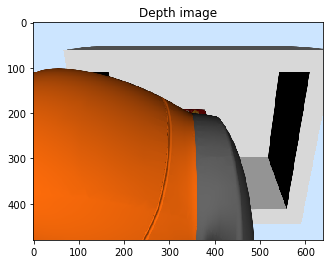

In [24]:
import matplotlib.pyplot as plt 
plt.imshow(np.squeeze(icp.inputs[5].data))
plt.title('Depth image')

res = icp.inputs[5].data

#and masks[i]['area'] > 30000
masks = mask_generator.generate(res[:,:,:3])
for i in range(len(masks)):
    if (masks[i]['stability_score'] > 0.99  ):
        image = np.array(masks[i]["segmentation"])
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.axis('off')
        plt.show()



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=29fb9f43-5ddf-4394-96be-7b378ea2c223' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>